<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pyspark
!pip install haversine

# Load CSV data into Spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType
import os
import glob
import datetime
from haversine import haversine, Unit, inverse_haversine
import numpy as np

airport = (51.871496514, -0.367665196) # Luton
diag_distance = 25
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

spark = SparkSession.builder.appName('opensky').getOrCreate()

schema = StructType([ \
    StructField('time', LongType(), False), \
    StructField('icao24', StringType(), True), \
    StructField('lat', FloatType(), True), \
    StructField('lon', FloatType(), True), \
    StructField('velocity', FloatType(), True), \
    StructField('heading', FloatType(), True), \
    StructField('vertrate', FloatType(), True), \
    StructField('callsign', StringType(), True), \
    StructField('onground', BooleanType(), True), \
    StructField('alert', BooleanType(), True), \
    StructField('spi', BooleanType(), True), \
    StructField('squawk', FloatType(), True), \
    StructField('baroaltitude', FloatType(), True), \
    StructField('geoaltitude', FloatType(), True), \
    StructField('lastposupdate', FloatType(), True), \
    StructField('lastcontact', FloatType(), True), \
    StructField('hour', LongType(), True) \
])

folder_path = '/content/drive/MyDrive/opportunistic-utm/data'
file_names = []

for filename in glob.iglob(folder_path + '/**/*.csv', recursive=True):
  file_names.append(filename)

opensky_df = spark.read.option('header', True).csv(path=file_names, schema=schema)
# opensky_df = opensky_df.sort('time')
opensky_df.show(10)

+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+
|      time|icao24|      lat|         lon|velocity|  heading|vertrate|callsign|onground|alert|  spi|squawk|baroaltitude|geoaltitude|lastposupdate|lastcontact|      hour|
+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+
|1497139225|400755|51.918453| -0.11943708| 72.8715|255.27702|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|
|1497139226|400755|51.918274| -0.12046814|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|
|1497139227|400755|51.918083|-0.121398926|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|false|7774.0|      998.22|      990.6|  1.4971392E9|1.49

In [ ]:
opensky_df.printSchema()

root
 |-- time: long (nullable = true)
 |-- icao24: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- velocity: float (nullable = true)
 |-- heading: float (nullable = true)
 |-- vertrate: float (nullable = true)
 |-- callsign: string (nullable = true)
 |-- onground: boolean (nullable = true)
 |-- alert: boolean (nullable = true)
 |-- spi: boolean (nullable = true)
 |-- squawk: float (nullable = true)
 |-- baroaltitude: float (nullable = true)
 |-- geoaltitude: float (nullable = true)
 |-- lastposupdate: float (nullable = true)
 |-- lastcontact: float (nullable = true)
 |-- hour: long (nullable = true)



In [ ]:
print((opensky_df.count(), len(opensky_df.columns)))

(73780207, 17)


# Plot hourly data

In [ ]:
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt
from pyspark.sql.functions import days
%config InlineBackend.figure_format = 'retina'

subset = opensky_df.groupBy('hour').agg(countDistinct('callsign'))
df = subset.toPandas()
df = df.sort_values(by=['hour']).reset_index(drop=True)

In [ ]:
df.head()

,hour,count(callsign)
0,1483228800,1
1,1483250400,7
2,1483254000,12
3,1483257600,7
4,1483261200,11


Text(0.5, 1.0, 'Luton Airport - Number of Daily Flights (0 to 1000 ft)')

<Figure size 432x288 with 0 Axes>

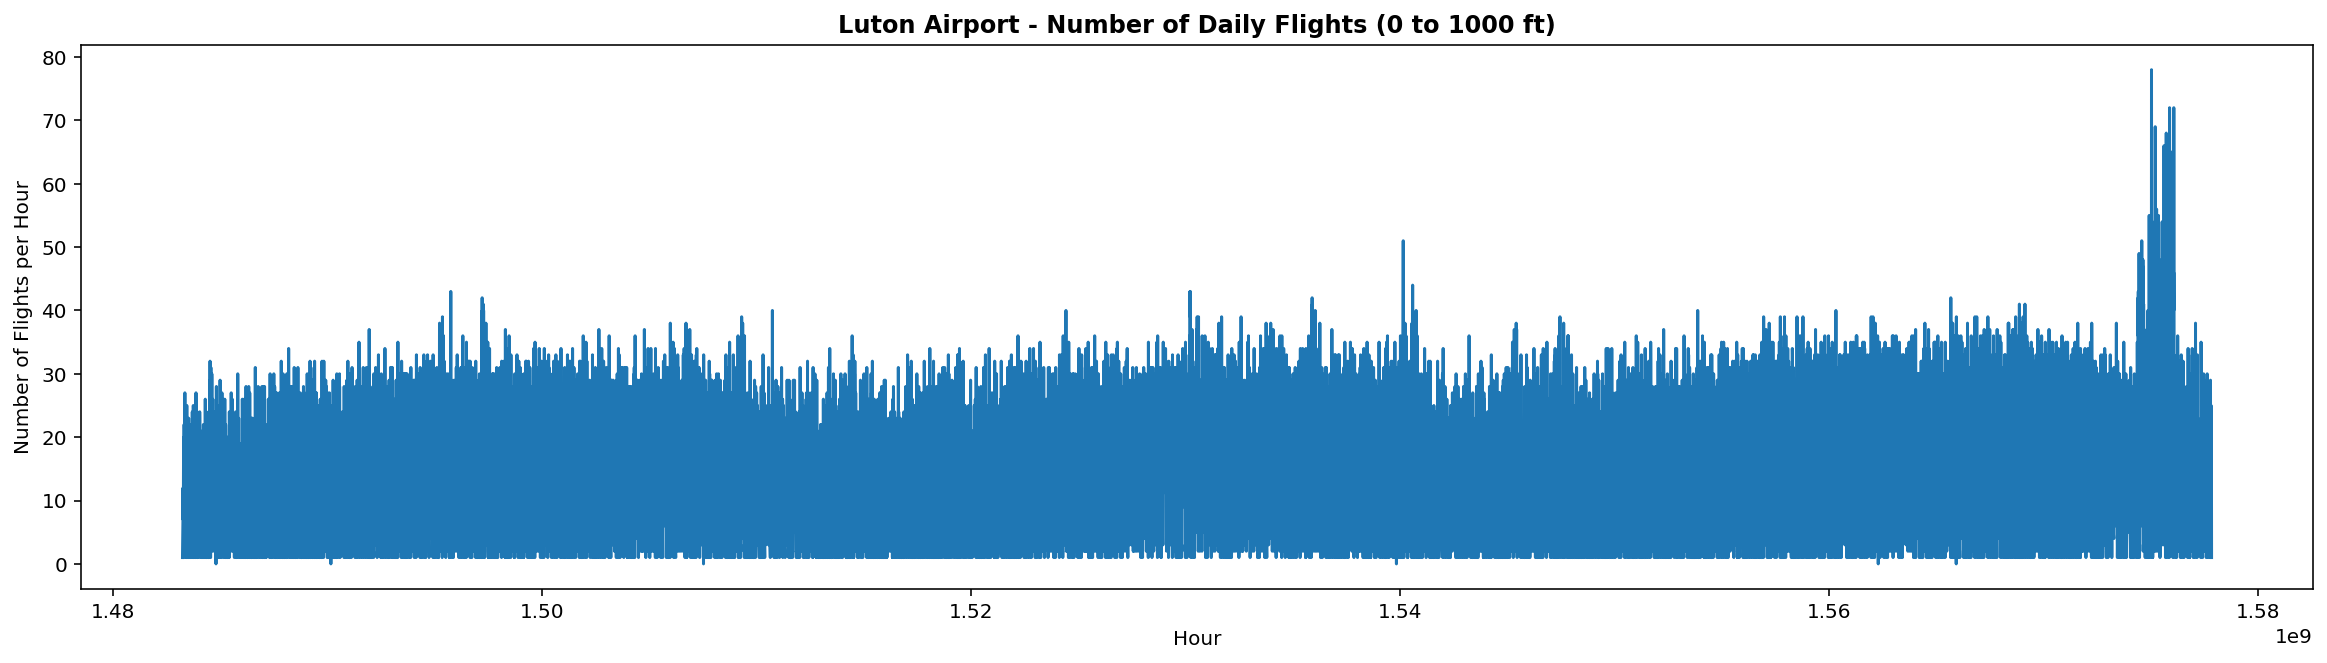

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['hour'], df['count(callsign)'])
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Flights per Hour')
ax.set_title('Luton Airport - Number of Daily Flights (0 to 1000 ft)', fontweight='bold')

# Grid data

In [ ]:
datetime(2019, 12, 13, 6, 0, 0).replace(tzinfo=timezone.utc).timestamp()

1576216800.0

In [ ]:
np.linspace(3,31,29)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31.])

In [ ]:
from datetime import timezone
from datetime import datetime
from haversine import haversine, Unit, inverse_haversine
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType, IntegerType
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
import math
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import numpy as np
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output
import os

# Calculate distances to airport
airport = (51.87626460000001, -0.3717470999999932) # Luton
diag_distance = 3.5
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

# Query
year = 2019
month = 1
days = np.linspace(1,31,31)

for day in tqdm(days):
  hour_start = datetime(year, month, int(day), 0, 0, 0).replace(tzinfo=timezone.utc).timestamp()
  hour_end = datetime(year, month, int(day), 23, 59, 59).replace(tzinfo=timezone.utc).timestamp()

  day_subset = opensky_df.where(
                                # (opensky_df.hour >= start_day) & 
                                # (opensky_df.hour <= end_day) &
                                (opensky_df.lat >= min_lat) &
                                (opensky_df.lat < max_lat) &
                                (opensky_df.lon >= min_lon) &
                                (opensky_df.lon < max_lon) &
                                (opensky_df.geoaltitude >= 0) & 
                                (opensky_df.geoaltitude < 1000) &
                                (opensky_df.hour >= hour_start) &
                                (opensky_df.hour <= hour_end)
                              )

  # def epoch_to_utc(hour_in_unix_time):
  #   return datetime.datetime.utcfromtimestamp(hour_in_unix_time)
  # utc = udf(epoch_to_utc, DateType())

  # def feet_to_metres(feet_units):
  #   return feet_units * 0.3048
  # ft_to_m = udf(feet_to_metres, FloatType())

  def calculate_west_east_distance(destination_longitude):
    return haversine(min_coord, (min_coord[0], destination_longitude), unit=Unit.METERS) # (lat, lon)
  we_distance = udf(calculate_west_east_distance, FloatType())

  def calculate_north_south_distance(destination_latitude):
    return haversine(min_coord, (destination_latitude, min_coord[1]), unit=Unit.METERS) # (lat, lon)
  ns_distance = udf(calculate_north_south_distance, FloatType())

  def calculate_pixel_distance(destination_distance):
    return math.floor(destination_distance/100)
  px_distance = udf(calculate_pixel_distance, IntegerType())

  def calculate_pixel_altitude(destination_altitude):
    altitude_level = math.floor((destination_altitude-160)/100)
    if altitude_level >= 0:
      return altitude_level
    else:
      return 0

  px_altitude = udf(calculate_pixel_altitude, IntegerType())

  # opensky_df = opensky_df.withColumn('timestamp', utc('hour'))
  # opensky_df = opensky_df.withColumn('altitude', ft_to_m('geoaltitude'))
  day_subset = day_subset.withColumn('we_distance', we_distance('lon'))
  day_subset = day_subset.withColumn('ns_distance', ns_distance('lat'))
  day_subset = day_subset.withColumn('we_px', px_distance('we_distance'))
  day_subset = day_subset.withColumn('ns_px', px_distance('ns_distance'))
  day_subset = day_subset.withColumn('alt_px', px_altitude('geoaltitude'))

  # print((day_subset.count(), len(day_subset.columns)))
  # day_subset.show(10)


  epoch_hour = hour_start # start hour
  hour_subset = day_subset.toPandas().groupby(['hour', 'alt_px', 'ns_px', 'we_px']).agg({'icao24': 'count'}).reset_index()

  cmap = plt.cm.get_cmap('brg', 10)
  for i in range(0, 24):
    matrix = np.zeros((8,50,50))

    try:
      image_subset = hour_subset[hour_subset['hour'] == epoch_hour].reset_index(drop=True)
      # image_subset = image_subset.groupby(['alt_px', 'ns_px', 'we_px']).agg({'icao24': 'count'}).reset_index()

      for j in range(0, len(hour_subset)):
        matrix[image_subset['alt_px'][j]][image_subset['ns_px'][j]][image_subset['we_px'][j]] = 1
    except:
      pass
    
    # cmap = mpl.colors.ListedColormap(['black','white', 'blue', 'green', 'yellow'])
    max_matrix = np.amax(matrix, axis = 0)
    img = plt.imshow(max_matrix, cmap = plt.get_cmap('plasma'), origin='lower')
    plt.show()
    
    # Save
    working_folder = f'/content/drive/MyDrive/opportunistic-utm/dataset/{year}-{str(month).zfill(2)}/{year}-{str(month).zfill(2)}-{str(int(day)).zfill(2)}'

    if not os.path.exists(f'{working_folder}'):
      os.makedirs(f'{working_folder}')

    if not os.path.exists(f'{working_folder}/img'):
      os.makedirs(f'{working_folder}/img')
    
    np.save(f'{working_folder}/{int(epoch_hour)}.npy', matrix)
    plt.imsave(f'{working_folder}/img/{int(epoch_hour)}.png', max_matrix, origin='lower')

    print(f'\nCompleted: {int(epoch_hour)}')
    epoch_hour += 3600


In [19]:
hour_subset.head()

,hour,alt_px,ns_px,we_px,icao24
0,1548892800,0,23,28,2
1,1548892800,0,23,29,4
2,1548892800,0,23,30,3
3,1548892800,0,24,30,1
4,1548892800,0,24,31,3


# Visualize map

In [ ]:
!pip install contextily
!pip install pyproj

In [ ]:
pd_image_subset = day_subset.where(day_subset.hour == 1559415600).toPandas()

<Figure size 432x288 with 0 Axes>

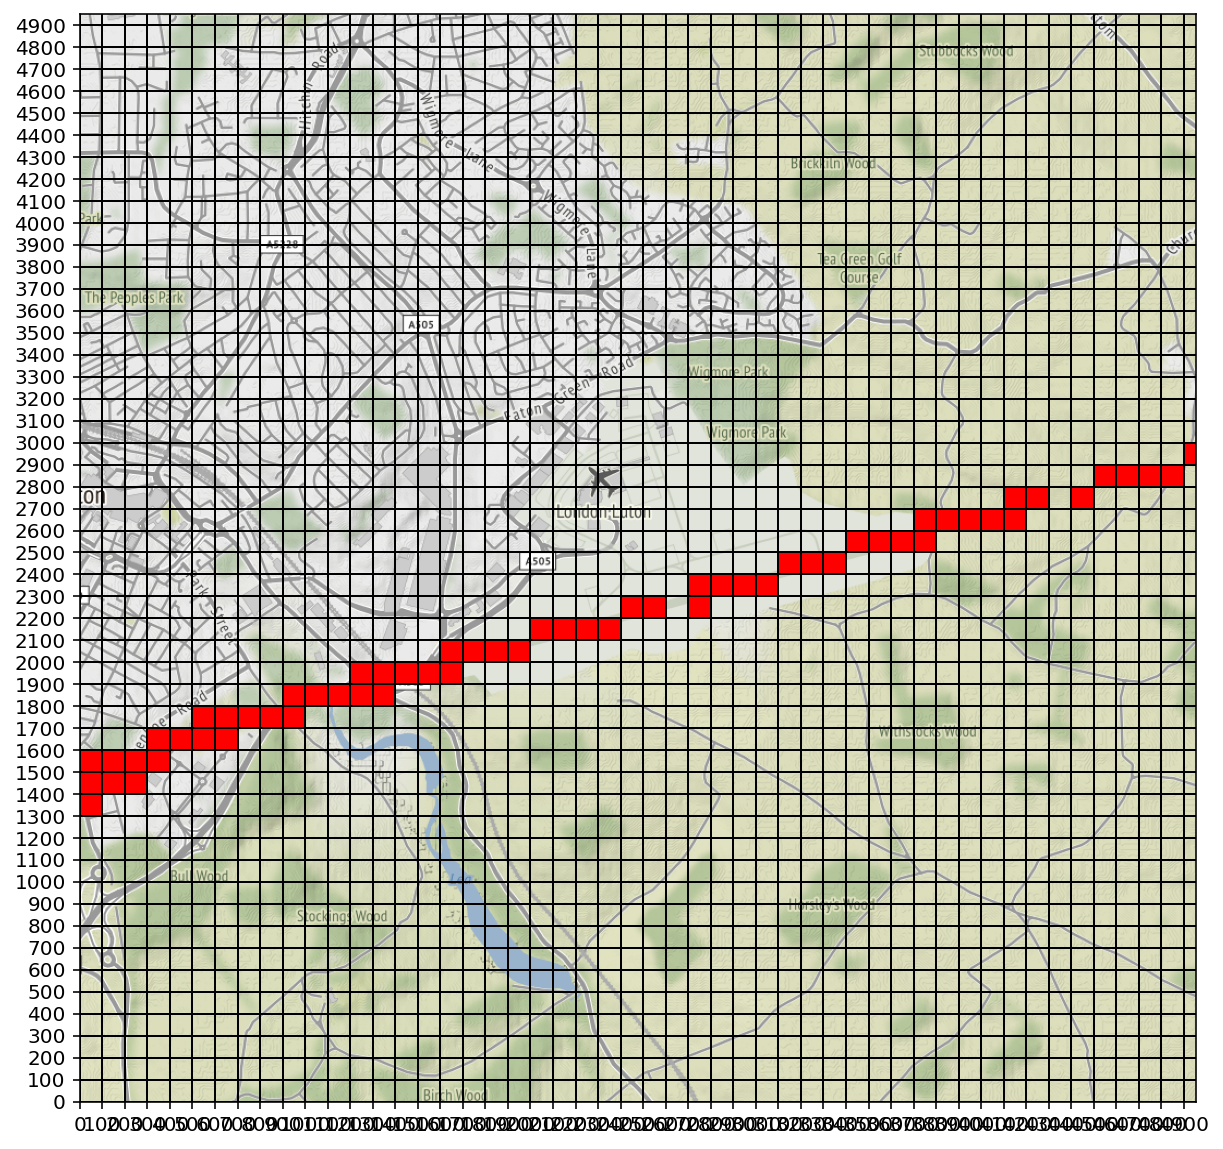

In [ ]:
import contextily as cx
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure()
fig, ax = plt.subplots(figsize=(10,10))

ghent_img, ghent_ext = cx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=cx.providers.Stamen.Terrain)
we_distance = haversine(min_coord, (min_lat, max_lon), unit=Unit.METERS)
ns_distance = haversine(min_coord, (max_lat, min_lon), unit=Unit.METERS)

ax.imshow(ghent_img, extent=(0, we_distance, 0, ns_distance))
# ax.scatter(pd_image_subset['we_distance'], pd_image_subset['ns_distance'])
# for k in range(0, len(pd_image_subset)):
#   ax.plot(pd_image_subset['we_distance'][k], pd_image_subset['ns_distance'][k], '-', marker=(3, 0, -pd_image_subset['heading'][k]), markersize=15, color='blue')

ax.set_xticks(np.arange(0, 5000, 100))
ax.set_yticks(np.arange(0, 5000, 100))
ax.grid(color='black', linewidth = 1, which='both')

for i in range(0, len(pd_image_subset)):
  rect = patches.Rectangle((pd_image_subset['we_px'][i]*100, pd_image_subset['ns_px'][i]*100), 100, 100, facecolor='red')
  ax.add_patch(rect)

ax.set_aspect('auto')